In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')
print("Tensorflow", tf.__version__)


Tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

4 Physical GPUs, 1 Logical GPU


## Download Datset

In [3]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

## Input Pipeline
Although Tensorflow Datasets contain this dataset but the masks and real images are not ordered in pair and is therefore not fit for purpose. Thus, we will use the image pipeline from Tensorflow tutorial at https://www.tensorflow.org/tutorials/generative/pix2pix. 

In [4]:
image_shape = (256, 256, 3)
IMG_HEIGHT = image_shape[0]
IMG_WIDTH = image_shape[1]

In [5]:
BATCH_SIZE = 1
BUFFER_SIZE = 400

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

'''
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)
'''

"\ninp, re = load(PATH+'train/100.jpg')\n# casting to int for matplotlib to show the image\nplt.figure()\nplt.imshow(inp/255.0)\nplt.figure()\nplt.imshow(re/255.0)\n"

In [6]:
class PIX2PIX():
    def __init__(self, input_shape):
        self.input_shape = input_shape

        # discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = False
        self.optimizer_discriminator = Adam(2e-4, 0.5, 0.9999)
                
        # build generator pipeline with frozen discriminator
        self.generator = self.build_generator()
        discriminator_output = self.discriminator([self.generator.input, 
                                                   self.generator.output])
        self.patch_size = discriminator_output.shape[1]
        self.model = Model(self.generator.input, discriminator_output)
        self.LAMBDA = 100
        self.model.compile(loss = ['bce','mae'],
                           optimizer = Adam(2e-4, 0.5, 0.9999),
                           loss_weights=[1, self.LAMBDA])
        self.discriminator.trainable = True
        self.bce = tf.keras.losses.BinaryCrossentropy()
        
    def bce_loss(self, y_true, y_pred):
        
        loss = self.bce(y_true, y_pred)

        return loss
    
    def downsample(self, channels, kernels, strides=2, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def upsample(self, channels, kernels, strides=1, norm=True, activation=True, dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)
        block = tf.keras.Sequential()
        block.add(layers.UpSampling2D((2,2)))
        block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))

        if norm:
            block.add(InstanceNormalization())              
        if activation:
            block.add(layers.LeakyReLU(0.2)) 
        if dropout:
            block.add(layers.Dropout(0.5))

        return block

    def build_generator(self):

        DIM = 64

        input_image = layers.Input(shape=image_shape)
        down1 = self.downsample(DIM, 4, norm=False)(input_image) # 128, DIM
        down2 = self.downsample(2*DIM, 4)(down1) # 64, 2*DIM
        down3 = self.downsample(4*DIM, 4)(down2) # 32, 4*DIM
        down4 = self.downsample(4*DIM, 4)(down3) # 16, 4*DIM
        down5 = self.downsample(4*DIM, 4)(down4) # 8, 4*DIM
        down6 = self.downsample(4*DIM, 4)(down5) # 4, 4*DIM
        down7 = self.downsample(4*DIM, 4)(down6) # 2, 4*DIM


        up6 = self.upsample(4*DIM, 4, dropout=True)(down7) # 4,4*DIM
        concat6 = layers.Concatenate()([up6, down6])   

        up5 = self.upsample(4*DIM, 4, dropout=True)(concat6) 
        concat5 = layers.Concatenate()([up5, down5]) 

        up4 = self.upsample(4*DIM, 4, dropout=True)(concat5) 
        concat4 = layers.Concatenate()([up4, down4]) 

        up3 = self.upsample(4*DIM, 4)(concat4) 
        concat3 = layers.Concatenate()([up3, down3]) 

        up2 = self.upsample(2*DIM, 4)(concat3) 
        concat2 = layers.Concatenate()([up2, down2]) 

        up1 = self.upsample(DIM, 4)(concat2) 
        concat1 = layers.Concatenate()([up1, down1]) 

        output_image = tanh(self.upsample(3, 4, norm=False, activation=False)(concat1))

        return Model(input_image, output_image, name='generator')         
    
    def build_discriminator(self):
        DIM = 64
        model = tf.keras.Sequential(name='discriminators') 
        input_image_A = layers.Input(shape=image_shape)
        input_image_B = layers.Input(shape=image_shape)
        
        x = layers.Concatenate()([input_image_A, input_image_B])
        x = self.downsample(DIM, 4, norm=False)(x) # 128
        x = self.downsample(2*DIM, 4)(x) # 64
        x = self.downsample(4*DIM, 4)(x) # 32
        x = self.downsample(8*DIM, 4, strides=1)(x) # 29
        output = layers.Conv2D(1, 4, activation='sigmoid')(x)

        return Model([input_image_A, input_image_B], output)     
    
    def train_discriminator(self, real_images_A, real_images_B, batch_size):
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))
                  
        fake_images_B = self.generator.predict(real_images_A)
        
        with tf.GradientTape() as gradient_tape:
            
            # forward pass
            pred_fake = self.discriminator([real_images_A, fake_images_B])
            pred_real = self.discriminator([real_images_A, real_images_B])
            
            # calculate losses
            loss_fake = self.bce_loss(fake_labels, pred_fake)
            loss_real = self.bce_loss(real_labels, pred_real)           
            
            # total loss
            total_loss = 0.5*(loss_fake + loss_real)
            
            # apply gradients
            gradients = gradient_tape.gradient(total_loss, self.discriminator.trainable_variables)
            
            self.optimizer_discriminator.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return loss_fake, loss_real
    
    def train(self, data_generator, test_data_generator, batch_size, steps, interval=100):
        val_images = next(test_data_generator) 
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        self.batch_size = batch_size
        for i in range(steps):
    
            real_images_A, real_images_B = next(data_generator)
            loss_fake, loss_real = self.train_discriminator(real_images_A, real_images_B, batch_size)
            discriminator_loss = 0.5*(loss_fake + loss_real)
                
            # train generator
            g_loss = self.model.train_on_batch([real_images_A, real_images_B], real_labels)
            if i%interval == 0:
                msg = "Step {}: discriminator_loss {:.4f} g_loss {:.4f}"\
                .format(i, discriminator_loss, g_loss)
                print(msg)
                
                fake_images = self.generator.predict(val_images[0])
                self.plot_images(val_images, fake_images)
            
    def plot_images(self, real_images, fake_images):   
        grid_row = min(fake_images.shape[0], 4)
        grid_col = 3
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*6, grid_row*6))
        for row in range(grid_row):
            ax = axarr if grid_row==1 else axarr[row]
            ax[0].imshow((real_images[0][row]+1)/2)
            ax[0].axis('off') 
            ax[1].imshow((real_images[1][row]+1)/2)
            ax[1].axis('off') 
            ax[2].imshow((fake_images[row]+1)/2)
            ax[2].axis('off') 
        plt.show()
        
    def sample_images(self, number):
        z = tf.random.normal((number, self.z_dim))
        images = self.generator.predict(z)
        self.plot_images(images)
        return images
    
pix2pix = PIX2PIX(image_shape)


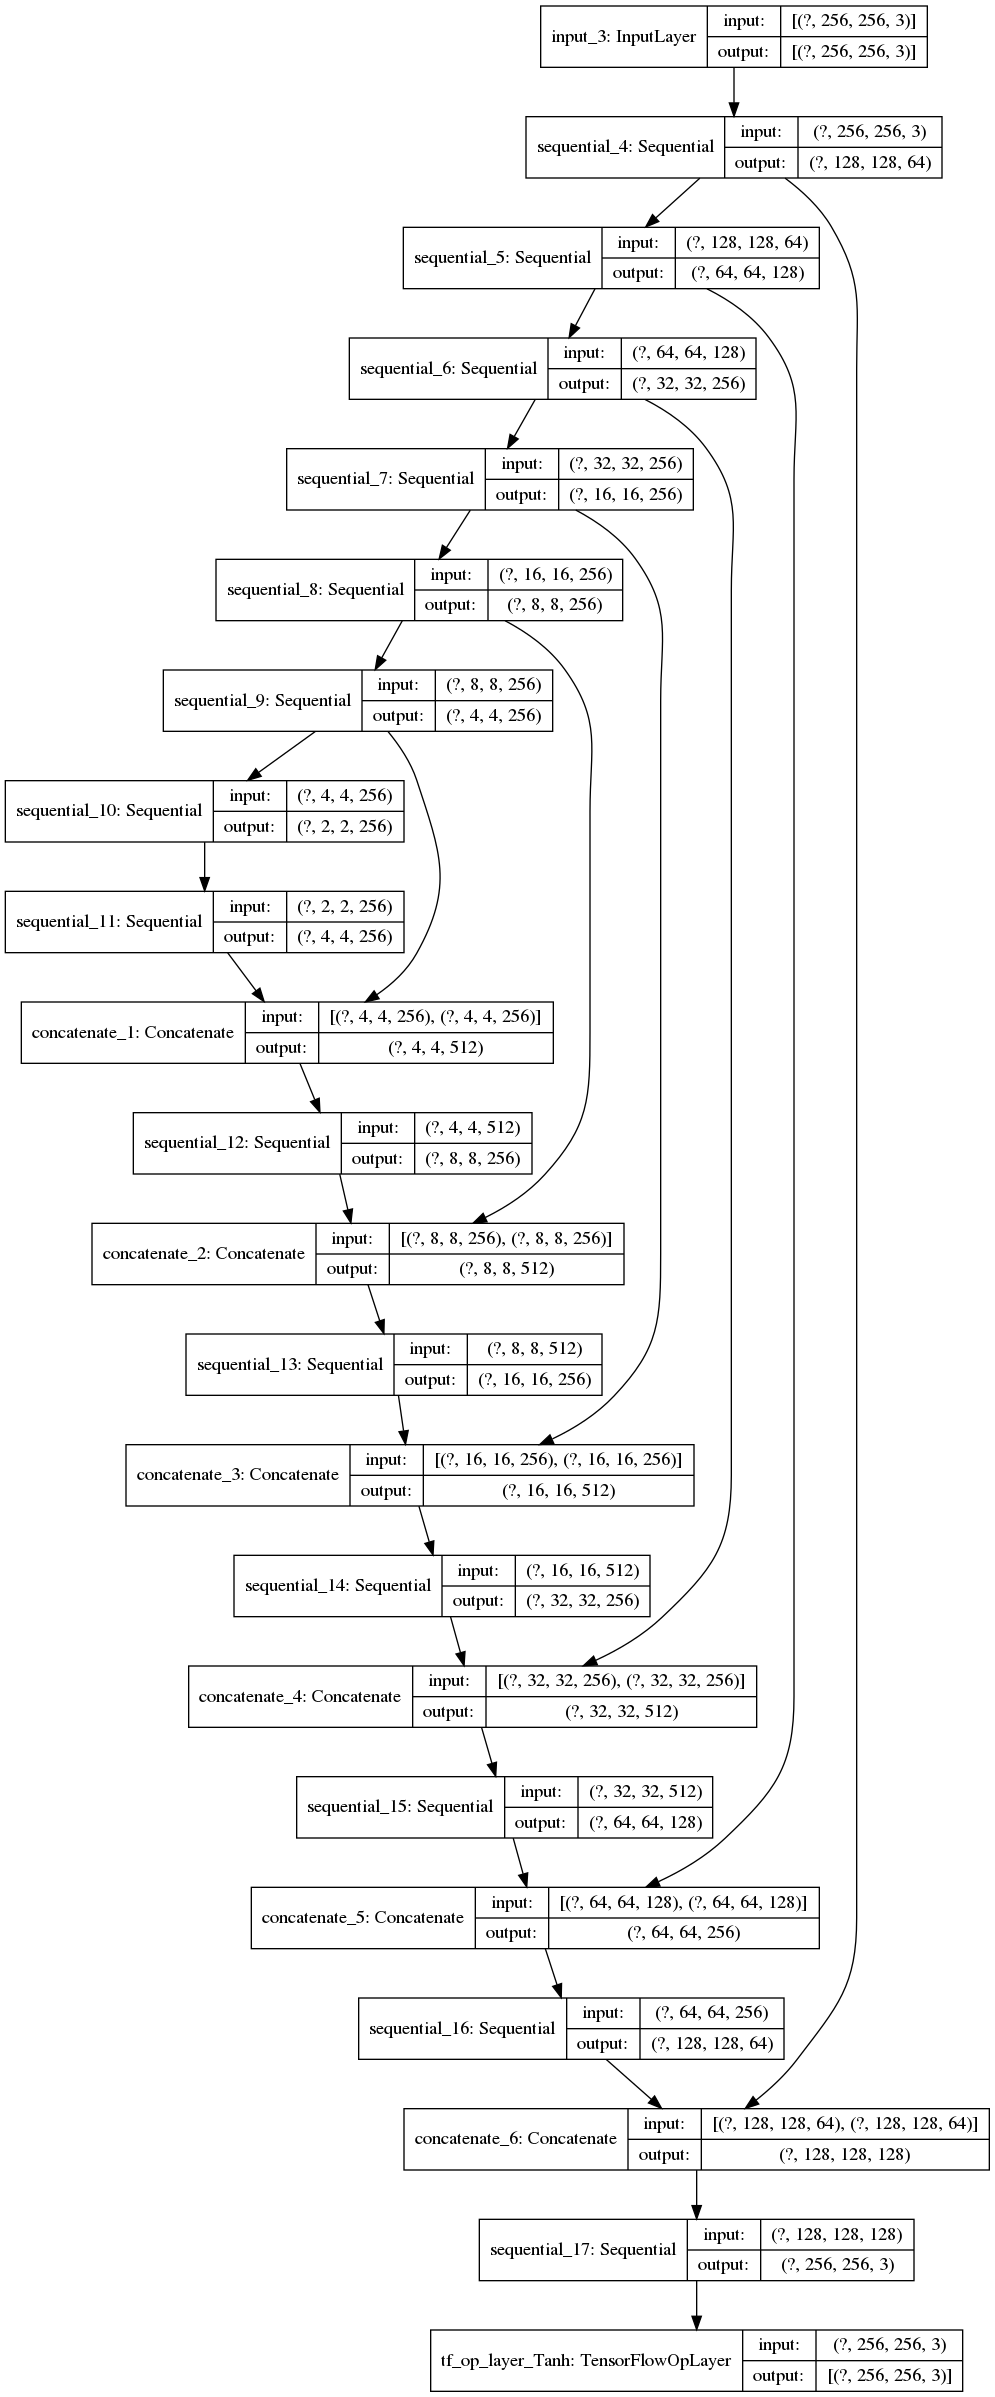

In [10]:
tf.keras.utils.plot_model(pix2pix.generator, show_shapes=True)

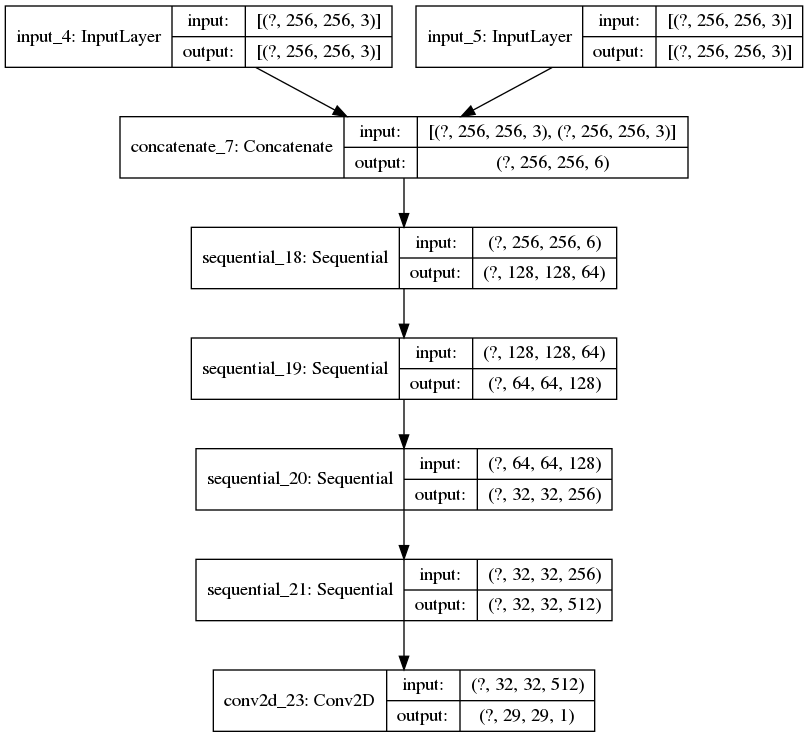

In [38]:
tf.keras.utils.plot_model(pix2pix.discriminator, show_shapes=True)

In [ ]:
pix2pix.train(iter(train_dataset), iter(test_dataset), BATCH_SIZE, 20000, 1000)

In [21]:
pix2pix.generator.save("./models/pix2pix_landscape")

INFO:tensorflow:Assets written to: ./models/pix2pix_landscape/assets


In [7]:
pix2pix.generator = tf.keras.models.load_model("./models/pix2pix_landscape")

In [8]:
test_iterator = iter(test_dataset)

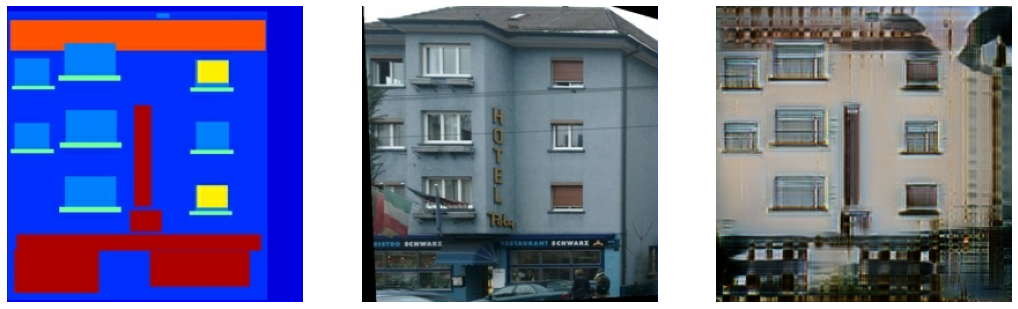

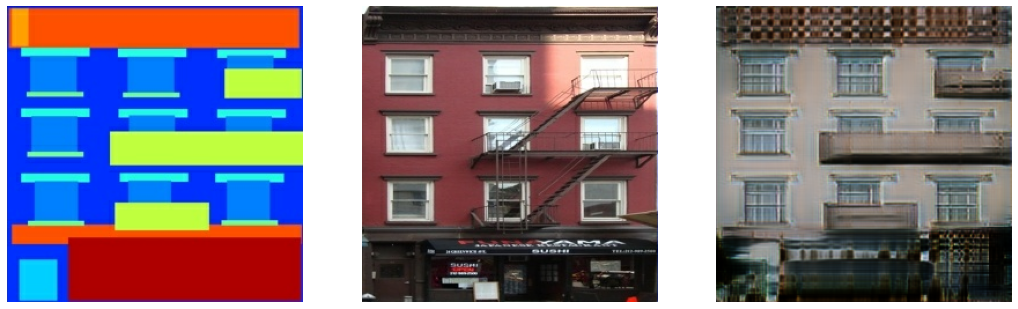

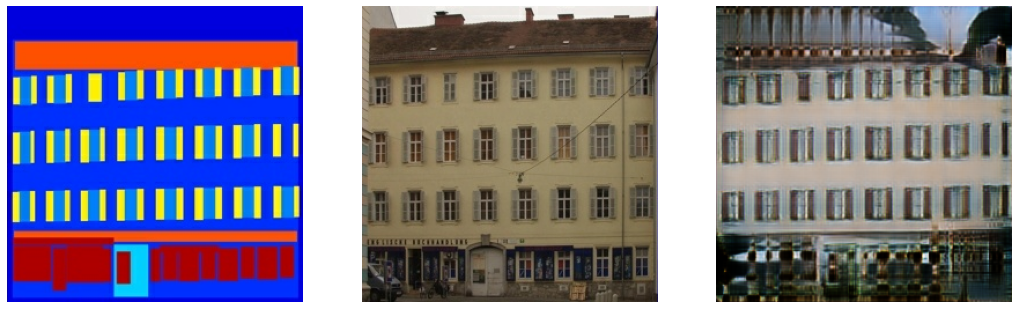

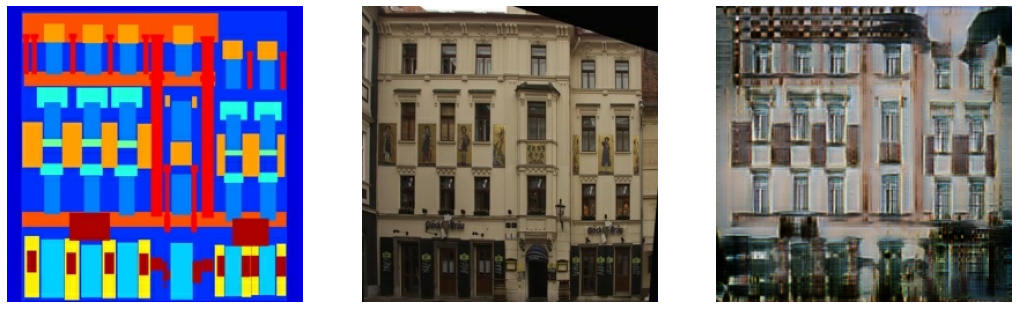

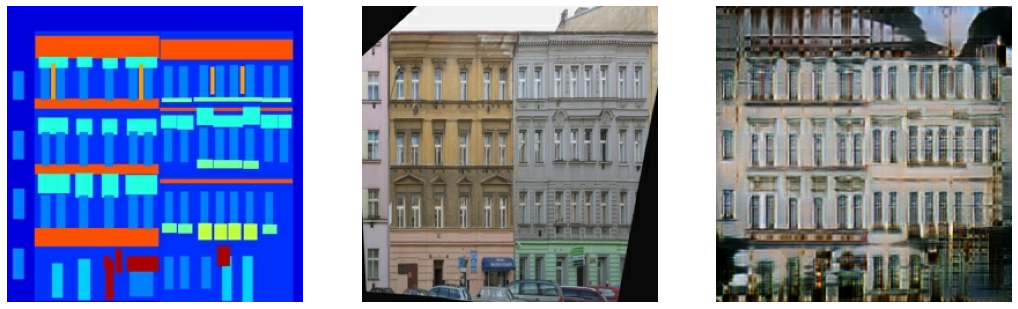

In [15]:
for _ in range(5):
    val_images = next(test_iterator) 
    fake_images = pix2pix.generator.predict(val_images[0])
    pix2pix.plot_images(val_images, fake_images)